# End-to-end Multi-class Dog Breed Classification

This notebook builts an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying a breed of a dog given an image of a dog.

## 2. Data

The data we're using is from Kaggle dog breed identification compition.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:
* We are dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set (these images have labels).
* There are around 10,000+ images in the test set (these images have no labels, because we want to predict them).


In [100]:
# Unzip the uploaded data into the Google Drive
#!unzip "drive/MyDrive/dog vision/dog-breed-identification.zip" -d "drive/MyDrive/dog vision/"

### Get our workspace ready

* Import TensorFlow2.x
* Import TensorFlow Hub
* Make sure we're using a GPU

In [101]:
# Import necessary tools
# Import TensorFlow & TensorFlow Hub into Colab
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "availabe (YESSS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.5.0
TF Hub version: 0.12.0
GPU availabe (YESSS!!!!)


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.

In [102]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/dog vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     0fbfe941d913c3976a13cc4925e67389  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [103]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


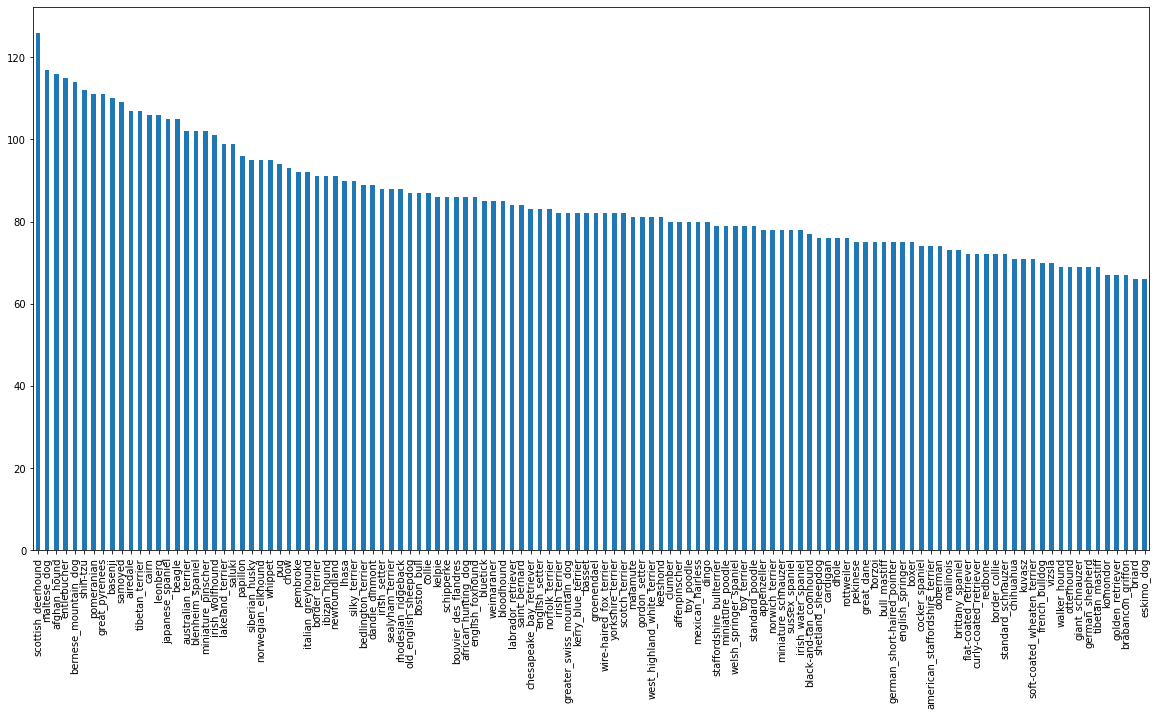

In [104]:
# How many images are there for each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [105]:
labels_csv["breed"].value_counts().median()

82.0

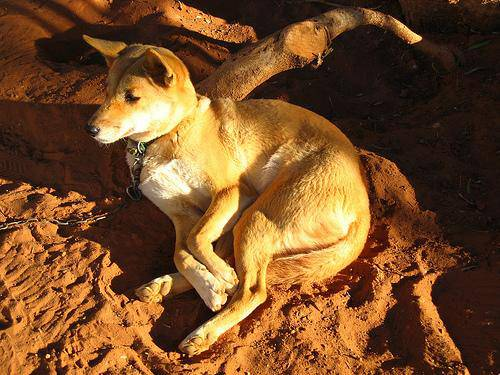

In [106]:
# Let's view an image
from IPython.display import Image
Image("drive/MyDrive/dog vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels

Let's get a list of all of our image file pathnames.

In [107]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [108]:
# Create pathnames from image ID's
filenames = ["drive/MyDrive/dog vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# check first 10
filenames[:10]

['drive/MyDrive/dog vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/dog vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/dog vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/dog vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/dog vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/dog vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/dog vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/dog vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/dog vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/dog vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [109]:
# check whether the number of filenames matches the number of actual image files
import os
if len(os.listdir("drive/MyDrive/dog vision/train/")) == len(filenames):
  print("Filenames match actual amount of files!!! Proceed.")
else:
  print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files!!! Proceed.


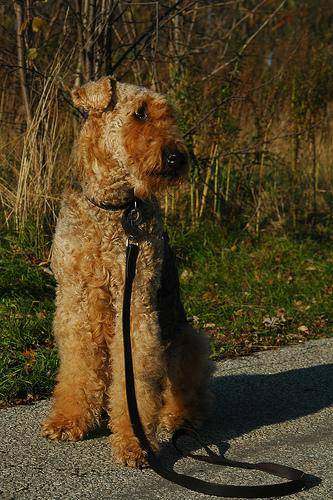

In [110]:
# One more check
Image(filenames[5000])

In [111]:
labels_csv["breed"][5000]

'airedale'

Since we've got our training image filepaths in a list, let's prepare our labels.

In [112]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels) # does same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [113]:
len(labels)

10222

In [114]:
# See if the number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches the number of filenames")
else:
  print("Number of labels does not match number of filenames, check the data directories")

Number of labels matches the number of filenames


In [115]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [116]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [117]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [118]:
len(boolean_labels)

10222

In [119]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1  where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set
Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [120]:
# Setup X & y variables
X = filenames
y = boolean_labels

We're going to start off experimenting with ~1000 images and increase as needed.

In [121]:
# Set a number of images to use for experimenting

In [122]:
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [123]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [124]:
# Let's have a quick look at the training data
X_train[:5], y_train[:2]

(['drive/MyDrive/dog vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/dog vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/dog vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/dog vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/dog vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, 

## Preprocessing Images (turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Resize the `image` to be a shape of (224, 224)
5. Return the modified `image`

Before we do, let's see what importing an image looks like.

In [125]:
# convert image into NumPy
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [126]:
image.max(), image.min()

(255, 0)

In [127]:
image[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [128]:
# Turn image into Tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them.

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert colour channel values from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`

In [129]:
# Define image size
IMG_SIZE = 224

# create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image filepath and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpg image into numerical Tensor with 3 color channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (244, 244)
  image = tf.image.resize(image, size=[img_size, img_size])
  return image

## Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10,000 in one go... they all might not fit into memory.

so that's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size if need be)

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this:
`(image, labels)`

In [130]:
# create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label, process the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

Now we've got a way to turn our data into tulpes of Tensors in the form of: `(image, label)`, let's make a function to turn all of our data `(x & y)` into batches!

In [131]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Let's create a function that turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) & label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """

  # if the data is a test dataset, we don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # Only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),   # filepaths
                                               tf.constant(y)))  # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths & labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples, (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [132]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [133]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now in batches, however, these can be hard to understand/comprehend, let's visualize them!

In [134]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")


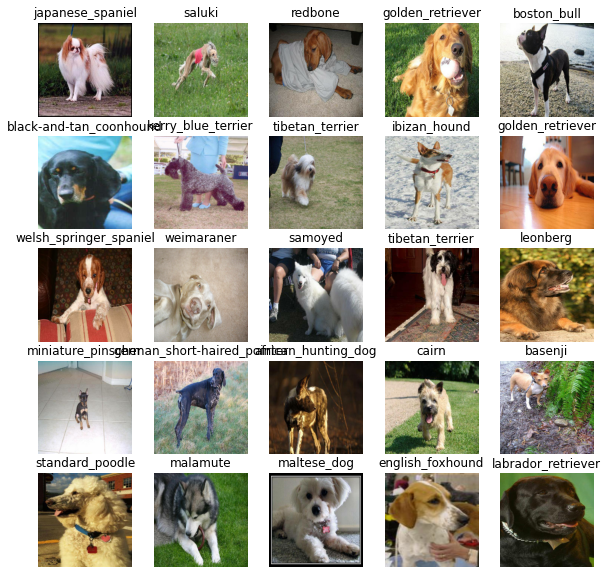

In [135]:
# Now let's visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

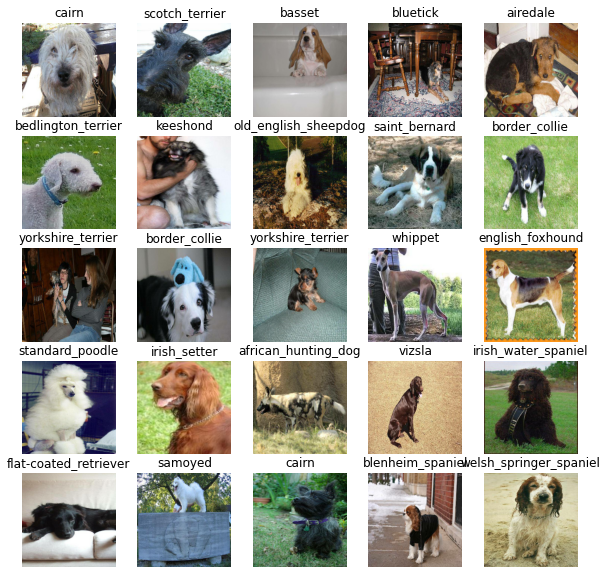

In [136]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a Model

Before we build a model, there are a few things we need to define:
* The input shape (images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5

In [137]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5" # updated version
           # https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4  # old version

Now we've got our inputs, outputs and model ready to go.
Let's put them together into a Keras deep learning model.

Knowing this, let's create a function which:
* Takes the input shape, output shape and model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting).
* Returns the model.

In [138]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
                               hub.KerasLayer(model_url), # Layer 1 (input layer)
                               tf.keras.layers.Dense(units=output_shape,
                                                     activation="softmax") # Layer 2 (output layer) # for binary classification, activation = sigmoid
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), # for binary classification, loss = Binary Crossentropy
      optimizer= tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(input_shape)

  return model

In [139]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1001)              5432713   
_________________________________________________________________
dense_3 (Dense)              (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks

Callbacks are helper functions a model can use during training to do things such as save it's progress, check it's progress or stop training early if model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and other for early stopping which prevents our model from training too long.

### TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize our models training logs with the `%tensorboard` magic fuction (we'll do this after model training).

In [140]:
# Load TensorBoard notebook  extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [141]:
import datetime

# Create a function to build TensorBoard callback
def create_tensorboard_callback():
  # create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/MyDrive/dog vision/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Ealry stopping helps our model from overfitting by stopping training if a certain evaluation metric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping


In [142]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training of model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [143]:
NUM_EPOCHS = 100 #@param {type: "slider", min:10, max:100, step:10}

In [144]:
# Check to make sure we're still running on GPU
print("GPU", "Available (YESSS!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU Available (YESSS!!!)


Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use.
* Return the model.

In [145]:
# Build a function to train and return a trainied model
def train_model():
  """
  Trains a given model and return a trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model

In [146]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/100
25/25 [==============================] - 10s 236ms/step - loss: 4.4687 - accuracy: 0.1125 - val_loss: 3.1735 - val_accuracy: 0.2800
Epoch 2/100
25/25 [==============================] - 4s 171ms/step - loss: 1.5661 - accuracy: 0.6988 - val_loss: 1.9907 - val_accuracy: 0.5250
Epoch 3/100
25/25 [==============================] - 4s 154ms/step - loss: 0.5378 - accuracy: 0.9450 - val_loss: 1.5789 - val_accuracy: 0.6150
Epoch 4/100
25/25 [==============================] - 4s 170ms/step - loss: 0.2388 - accuracy: 0.9900 - val_loss: 1.4150 - val_accuracy: 0.6400
Epoch 5/100
25/25 [==============================] - 4s 171ms/step - loss: 0.1400 - accuracy: 0.9975 - val_loss: 1.3505 - val_accuracy: 0.6350
Epoch 6/100
25/25 [==============================] - 4s 154ms/step - loss: 0.0967 - accuracy: 1.0000 - val_loss: 1.3100 - val_accuracy: 0.6450
Epoch 7/100
25/25 [=============================

**Question:** It looks like our model is overfitting because it's performing far better on the training dataset than on the validation dataset, what are some ways to prevent model overfitting in deep learning neural networks?

**Note:** Overfitting to begin with is a good thing! It means our model is learning!

### Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualize it's contents.

In [147]:
%tensorboard --logdir drive/MyDrive/dog\ vision/logs

Reusing TensorBoard on port 6006 (pid 473), started 2:44:56 ago. (Use '!kill 473' to kill it.)

<IPython.core.display.Javascript object>

## Making and Evaluating predictions using a trained model

In [148]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [149]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 2s 104ms/step


array([[9.4308908e-04, 2.4938781e-04, 6.2461401e-04, ..., 1.2921078e-04,
        1.5468562e-04, 2.3025198e-02],
       [1.7209214e-03, 8.3989999e-04, 7.1578352e-03, ..., 2.3268271e-04,
        6.5841881e-04, 4.2611413e-05],
       [1.6324617e-05, 2.2626216e-05, 6.1692066e-05, ..., 3.2734458e-04,
        1.6984439e-05, 4.0833322e-05],
       ...,
       [4.1096982e-07, 7.0752365e-05, 9.3269973e-06, ..., 6.5350569e-06,
        1.2437906e-04, 2.9977926e-05],
       [3.0380313e-03, 5.7873700e-04, 2.3577083e-04, ..., 1.5042536e-04,
        3.0136458e-04, 5.5579790e-03],
       [1.9278162e-04, 4.6009605e-05, 5.7554810e-04, ..., 4.2689606e-03,
        2.0944928e-03, 4.4699659e-04]], dtype=float32)

In [150]:
predictions.shape

(200, 120)

In [151]:
len(y_val)

200

In [152]:
len(unique_breeds)

120

In [153]:
predictions[0]

array([9.43089079e-04, 2.49387813e-04, 6.24614011e-04, 1.93189189e-04,
       6.93990674e-04, 6.64829640e-05, 2.34930664e-02, 2.52322364e-03,
       5.15087391e-04, 1.21883291e-04, 1.37737906e-03, 2.56685726e-05,
       5.00069233e-04, 1.58138530e-04, 3.10684583e-04, 2.46728607e-03,
       4.15215291e-05, 4.39441465e-02, 1.27986150e-05, 3.37743804e-05,
       8.45865114e-04, 7.56019494e-04, 4.01839898e-05, 9.54246847e-04,
       3.77032775e-05, 3.01698979e-04, 1.60718054e-01, 6.38101992e-05,
       4.03423066e-04, 8.60451197e-04, 2.69638520e-04, 3.10571864e-03,
       6.36476150e-04, 5.17621738e-05, 1.17959455e-04, 7.32215196e-02,
       1.99746326e-04, 7.54736015e-04, 9.22244944e-05, 1.34568705e-04,
       1.01407827e-03, 2.80069962e-05, 1.34631337e-05, 2.06837412e-05,
       1.34294547e-04, 1.60656578e-04, 1.78551840e-04, 2.15361462e-04,
       7.67362071e-04, 1.75601104e-03, 4.70995292e-05, 2.88228221e-05,
       5.02319075e-04, 2.29704438e-05, 4.91289647e-05, 1.93730521e-05,
      

In [154]:
# First prediction
index = 42
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[1.55822490e-04 7.12035690e-05 4.65000194e-05 1.71388485e-04
 4.92945220e-03 6.60592923e-05 2.60630506e-04 1.71785220e-03
 1.39899254e-02 3.17480080e-02 5.64416223e-05 3.62947067e-05
 8.06400261e-04 9.91355442e-03 1.57389254e-03 1.27668139e-02
 1.01496924e-04 4.69826162e-04 8.40184148e-05 3.88421468e-04
 1.36708972e-04 1.25104073e-03 9.57544107e-05 1.04482264e-04
 1.07526518e-02 1.63024684e-04 1.13942500e-04 3.74942101e-05
 2.32063045e-04 1.61893826e-04 1.64084449e-05 1.74479879e-04
 3.04697896e-04 7.47580270e-05 6.56826305e-05 4.44310972e-05
 3.20418534e-04 6.61089900e-04 1.40068019e-04 4.50142145e-01
 1.76502246e-04 1.09905013e-04 5.86908776e-03 8.42936515e-06
 2.97017465e-03 6.14788005e-05 3.78901343e-04 1.25278975e-03
 4.94612614e-05 1.65607591e-04 2.61842535e-04 1.80424948e-04
 8.21412366e-04 1.47180562e-03 2.76015817e-05 4.76960995e-04
 3.27618880e-04 7.59903560e-05 9.83739155e-05 5.86379756e-05
 3.83865263e-04 2.93600489e-03 4.52740751e-05 7.42204866e-05
 1.19904951e-04 2.381451

Having the above functionality is great but we want to be able to do it at scale.

And it would be even better if we could see the image the prediction is being made on!

**Note:** Prediction probabilities are also known as confidence levels.

In [155]:
# Turn prediction probabilities into their respective labels (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction of probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]
# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'irish_wolfhound'

Now since our validation data is stil in a batch dataset, we'll have to unbatch it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels)

In [156]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns seperate arrays of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we'vw ways to get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some functions to make these all a bit more visualize.

We'll create a function which:
* Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer.
* Convert the predicted probabilities to a predicted label.
* Plot the predicted label, it's predicted probability, the truth lable and the taget image on single plot.

In [157]:
def plot_pred(prediction_probabilities, labels, images, n=0):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending if the prediction is rigth or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"


  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)


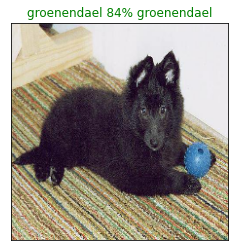

In [158]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

Now we've got one function to visualize our models top prediction, let's make another to view our models top 10 predictions.

This function will:
* Take an input of prediction probabilities array and a groud truth array and an integer
* Find the prediction using `get_pred_label()`
* Find the top 10:
  * Prediction probabilities indexes
  * Prediction probabilities values
  * Prediction labels
* Plot the Top 10 prediction probability values and labels, coloring the true label green

In [159]:
def plot_pred_conf(prediction_probabilities, labels, n=0):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change the color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

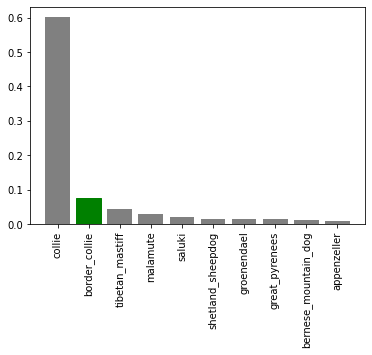

In [160]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

Now we've got some function to help us visualize our predictions and evaluate our models, let's check out a few.

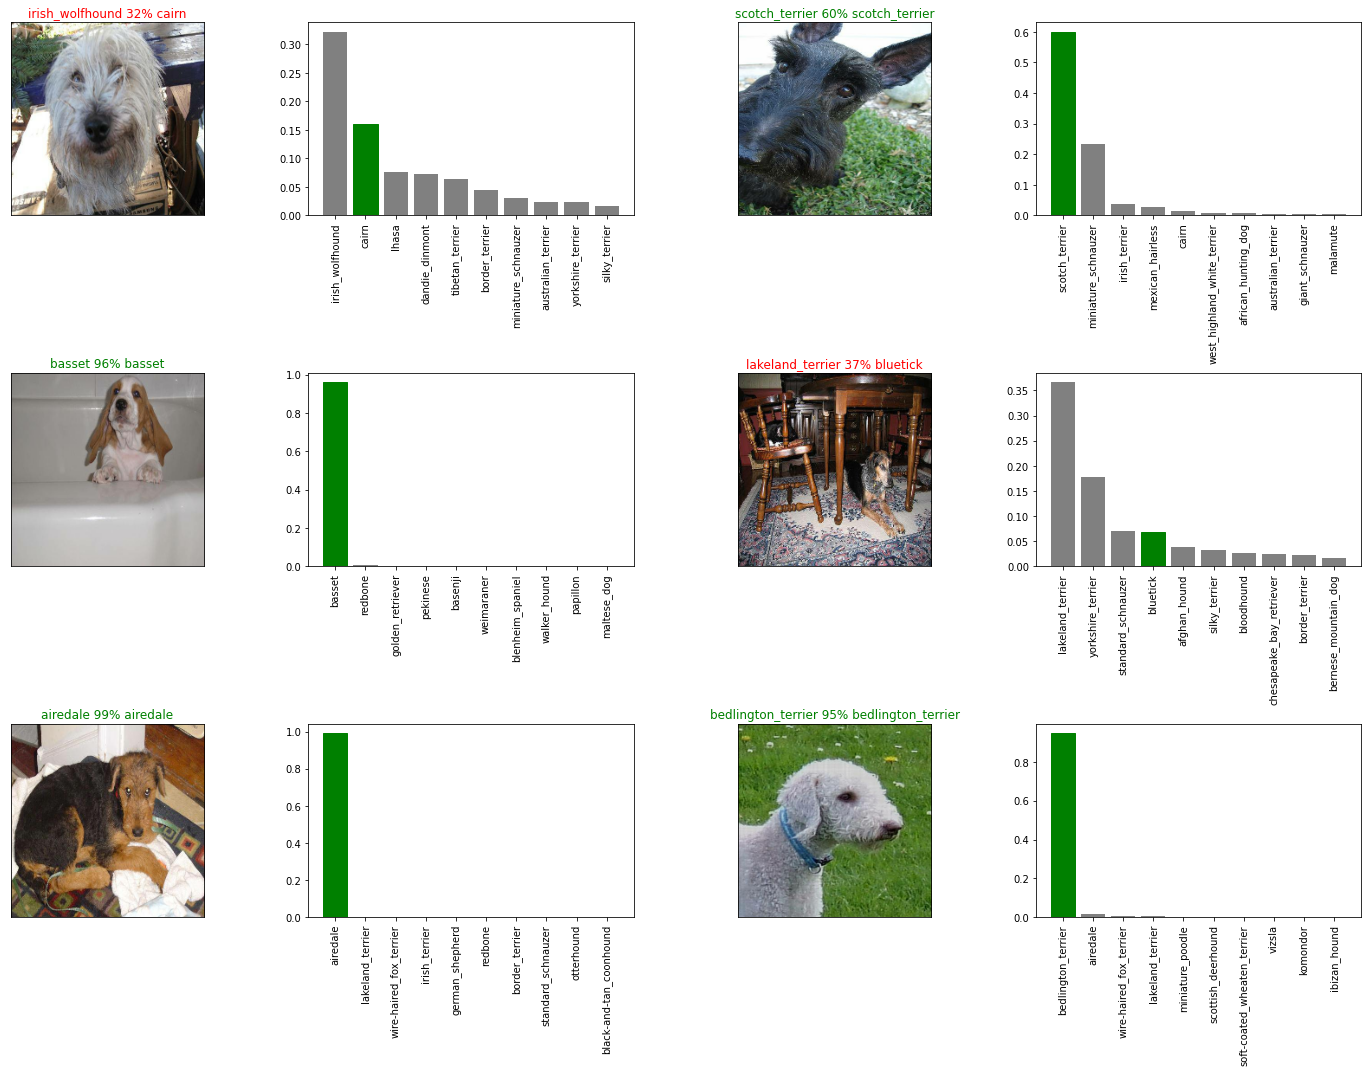

In [161]:
# Let's check out a few predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

**Challenge:** How would you create a confusion matrix with our models predictions and true labels

## Saving and Reloading a trained model

In [162]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/MyDrive/dog vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [163]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

Now we've got functions to save and load a trained model, let's make sure they work!

In [164]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-modilenetv2-Adam")

Saving model to: drive/MyDrive/dog vision/models/20210811-132230-1000-images-modilenetv2-Adam.h5...


'drive/MyDrive/dog vision/models/20210811-132230-1000-images-modilenetv2-Adam.h5'

In [165]:
# Load a trained model
loaded_1000_image_model = load_model("drive/MyDrive/dog vision/models/20210811-110734-1000-images-modilenetv2-Adam.h5")

Loading saved model from: drive/MyDrive/dog vision/models/20210811-110734-1000-images-modilenetv2-Adam.h5


In [166]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 113ms/step - loss: 1.2514 - accuracy: 0.6450


[1.2514208555221558, 0.6449999809265137]

In [167]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 104ms/step - loss: 1.2911 - accuracy: 0.6400


[1.2911447286605835, 0.6399999856948853]

## Training on big dog model (on the full data)

In [168]:
# Create a data batch with the full dataset
full_data = create_data_batches(X, y)

Creating training data batches...


In [169]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [170]:
# Create a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [171]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

**Note:** Running the cell below will take a little while (maybe upto 30 mins for the first epoch) because the GPU we're using in the runtime has to load all of the images into memory.

In [172]:
# # Fit the full model to full data
# full_model.fit(x=full_data,
#                epochs=NUM_EPOCHS,
#                callbacks=[full_model_tensorboard, full_model_early_stopping])

In [173]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: drive/MyDrive/dog vision/models/20210811-132239-full-image-set-mobilenetv2-Adam.h5...


'drive/MyDrive/dog vision/models/20210811-132239-full-image-set-mobilenetv2-Adam.h5'

In [174]:
# Load in the full model
loaded_full_model = load_model("drive/MyDrive/dog vision/models/20210811-124510-full-image-set-mobilenetv2-Adam.h5")

Loading saved model from: drive/MyDrive/dog vision/models/20210811-124510-full-image-set-mobilenetv2-Adam.h5


## Making predictions on test dataset

Since our data has been trianed on images in the form of Tensor batches, to make predictions on test dataset, we'll have to get it into the same format.

Luckily we created `create_data_batches()` earlier which can take a list of filenames as input and convert into Tensor batches.

To make predictions on test data, we'll:
* Get the test image filenames.
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since the test data doesn't have labels).
* Make a predictions array by passing the test batches to the `predict()` method called on your model.

In [175]:
# Load the test image filenames
test_path = "drive/MyDrive/dog vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/MyDrive/dog vision/test/e3d417026b89cbb57b00a7208421009d.jpg',
 'drive/MyDrive/dog vision/test/df69bb4b3dbdc81541e2bd70a5f35cb1.jpg',
 'drive/MyDrive/dog vision/test/e6920cc0fd2e3099506d23761d9682e1.jpg',
 'drive/MyDrive/dog vision/test/e646ac89e0832502f9a726c72773cfcc.jpg',
 'drive/MyDrive/dog vision/test/e2537e98808877c707bfe8ca53e303b7.jpg',
 'drive/MyDrive/dog vision/test/e0e47873420b2ed420e920a74c663233.jpg',
 'drive/MyDrive/dog vision/test/dea92807aa2ac37bbc2dabf1b0eb6a39.jpg',
 'drive/MyDrive/dog vision/test/e2915c191c0bc761b795b78f66845fe0.jpg',
 'drive/MyDrive/dog vision/test/e7dc8cc599049ea9fa2a172c88646c57.jpg',
 'drive/MyDrive/dog vision/test/e34bd9a8afc5280b5f2f7489f48c8e7d.jpg']

In [176]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [177]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

**Note:** Calling `predict()` on our full model and passing it the test data batch will take a long time to run (about an ~1hr)

In [178]:
# # Make predictions on test data batch using the loaded full model
# test_predictions = loaded_full_model.predict(test_data,
#                                              verbose=1)

324/324 [==============================] - 3403s 10s/step


In [180]:
# # Save predictions (NumPy array) to csv file (for access later)
# np.savetxt("drive/MyDrive/dog vision/preds_array.csv", test_predictions, delimiter=",")

In [181]:
# Load predictions (NumPy array) from csv file
test_predictions = np.loadtxt("drive/MyDrive/dog vision/preds_array.csv", delimiter=",")

In [182]:
test_predictions[:10]

array([[2.57697828e-08, 5.46032425e-06, 1.15045715e-07, ...,
        2.79803958e-09, 6.57583905e-06, 2.72393351e-07],
       [5.17477415e-11, 1.71729536e-12, 2.05319220e-10, ...,
        9.91103102e-11, 1.57732299e-11, 3.13585659e-12],
       [7.75681475e-09, 9.69226002e-12, 8.09548747e-11, ...,
        3.44331813e-10, 4.85147079e-13, 3.56924912e-09],
       ...,
       [4.68022554e-09, 3.89221259e-06, 4.02650402e-09, ...,
        2.48626347e-05, 4.15062059e-05, 2.70861520e-08],
       [9.78655180e-07, 9.91293803e-09, 1.13088805e-09, ...,
        6.28655114e-11, 1.48681886e-06, 7.35803738e-08],
       [7.20346038e-13, 3.30708900e-08, 1.38683798e-09, ...,
        4.11779354e-07, 6.46961684e-09, 6.00831107e-10]])

In [184]:
test_predictions.shape

(10357, 120)

## Preparing test dataset predictions for Kaggle

Looking at the Kaggle sample submission, we find that it wants our models predictions probability outputs in a DataFrame with an ID and a column for each different dog breed. https://www.kaggle.com/c/dog-breed-identification/data

To get the data in this format, we'll:
* Create a pandas DataFrame with an ID column as well as a column for each dog breed.
* Add data to the ID column by extracting the test image ID's from thier filepaths.
* Add data (the prediction probabilities) to each of the dog breed columns.
* Export the DataFrame as CSV to submit it to Kaggle.

In [186]:
# Create a Pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [189]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [190]:
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e3d417026b89cbb57b00a7208421009d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,df69bb4b3dbdc81541e2bd70a5f35cb1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,e6920cc0fd2e3099506d23761d9682e1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e646ac89e0832502f9a726c72773cfcc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e2537e98808877c707bfe8ca53e303b7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [191]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e3d417026b89cbb57b00a7208421009d,2.57698e-08,5.46032e-06,1.15046e-07,9.00756e-09,2.24379e-07,7.66812e-07,1.76072e-08,1.26219e-05,3.04074e-07,4.57526e-06,1.57206e-08,6.49599e-06,1.66485e-06,4.45773e-07,2.96527e-05,1.11313e-06,4.87388e-06,4.84108e-08,1.25077e-05,2.8742e-07,5.87648e-08,4.46054e-09,6.03711e-06,2.08953e-05,1.10074e-08,1.08262e-07,8.46247e-08,1.25322e-06,7.65087e-07,1.80727e-07,2.73271e-07,3.48289e-06,1.30846e-05,0.000129807,1.74046e-08,7.40186e-06,6.19703e-08,1.70879e-08,1.20144e-06,...,3.47799e-06,1.27957e-07,8.32548e-06,3.64527e-07,4.97393e-06,0.000188651,8.82939e-07,1.44368e-05,2.60232e-07,2.19977e-05,4.73922e-05,3.68858e-05,2.78841e-06,2.44203e-06,0.00052868,9.99869e-06,2.15145e-07,7.21035e-08,3.37525e-08,0.00618261,1.95202e-06,0.000558842,4.07219e-05,3.31928e-09,2.43942e-06,3.16804e-06,1.94704e-06,3.85617e-08,7.81039e-05,2.31841e-06,5.11368e-08,3.75227e-07,2.28004e-07,1.06295e-06,7.01867e-08,1.63502e-07,2.21315e-06,2.79804e-09,6.57584e-06,2.72393e-07
1,df69bb4b3dbdc81541e2bd70a5f35cb1,5.17477e-11,1.7173e-12,2.05319e-10,2.45247e-10,4.89871e-08,1.21873e-05,1.51377e-09,1.11037e-07,2.00985e-09,4.49253e-10,8.28841e-09,1.11947e-06,6.76947e-08,1.65781e-10,8.75127e-12,6.47259e-09,3.42819e-08,2.01239e-08,6.00064e-13,4.48007e-09,2.00728e-11,1.04591e-10,2.36677e-11,4.44592e-11,6.10691e-09,1.09547e-08,1.23775e-10,1.35895e-09,4.69504e-09,3.63723e-10,3.09094e-10,8.66802e-11,3.82164e-13,2.45764e-09,3.9438e-10,2.57548e-11,9.30596e-09,7.1772e-11,1.23613e-09,...,3.62387e-10,1.31746e-10,4.97197e-09,4.44974e-09,2.6641e-12,2.86577e-10,8.88747e-10,4.46735e-14,1.68975e-10,1.98433e-08,3.82841e-11,3.57028e-09,2.0931e-08,1.05144e-10,8.79967e-11,1.45049e-10,6.31903e-13,7.03519e-11,5.54098e-10,5.87516e-10,1.65132e-11,2.3347e-09,9.17559e-10,5.98e-10,3.21954e-11,5.37199e-11,1.65292e-10,4.24666e-10,7.35865e-09,1.05788e-08,1.50828e-09,8.40309e-12,4.42868e-11,5.94307e-09,9.92e-11,5.52969e-10,4.42269e-12,9.91103e-11,1.57732e-11,3.13586e-12
2,e6920cc0fd2e3099506d23761d9682e1,7.75681e-09,9.69226e-12,8.09549e-11,2.59647e-12,3.20449e-11,1.12538e-11,1.97157e-13,1.28009e-10,2.15435e-10,1.53012e-09,6.18864e-11,5.25275e-13,6.61452e-10,6.77792e-13,1.32447e-10,2.32542e-09,2.5682e-10,2.49417e-10,7.18056e-13,3.10808e-09,2.64882e-10,4.45042e-09,6.87729e-08,3.36771e-13,1.26412e-12,0.000133789,1.60915e-10,1.46023e-14,8.53946e-11,1.10884e-10,1.26935e-09,2.32136e-11,1.5192e-12,5.86216e-13,6.84207e-11,2.40573e-10,2.47977e-13,9.25124e-12,3.405e-10,...,1.98559e-09,1.67696e-14,8.86898e-11,6.41877e-12,2.96453e-14,1.88289e-08,1.80483e-13,1.70176e-11,0.999865,6.61547e-09,1.69513e-09,1.33658e-08,9.42811e-09,1.81193e-12,4.01159e-13,7.86303e-11,4.85437e-11,4.29934e-11,1.7385e-08,5.23879e-13,2.13682e-10,6.6612e-11,2.89501e-09,3.03837e-09,1.491e-10,7.42625e-14,3.91107e-11,8.97464e-11,8.25001e-14,2.47682e-11,7.90651e-11,2.37889e-11,1.52223e-12,9.30031e-13,9.06326e-09,4.13925e-13,5.86

In [192]:
# Save our predictions DataFrame to CSV for submission to Kaggle
preds_df.to_csv("drive/MyDrive/dog vision/full_model_predictions_submission_1_mobilenetv2.csv",
                index=False)